In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord, get_sun

from alerts import get_alerts, alerts_fn, get_closest_obs_df
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle

In [24]:
alerts = get_alerts()

In [40]:
times = Time(list(alerts["arrival time [UT]"]))
five_st_time = Time("2018-03-01")
alerts["five_stations"] = times > five_st_time

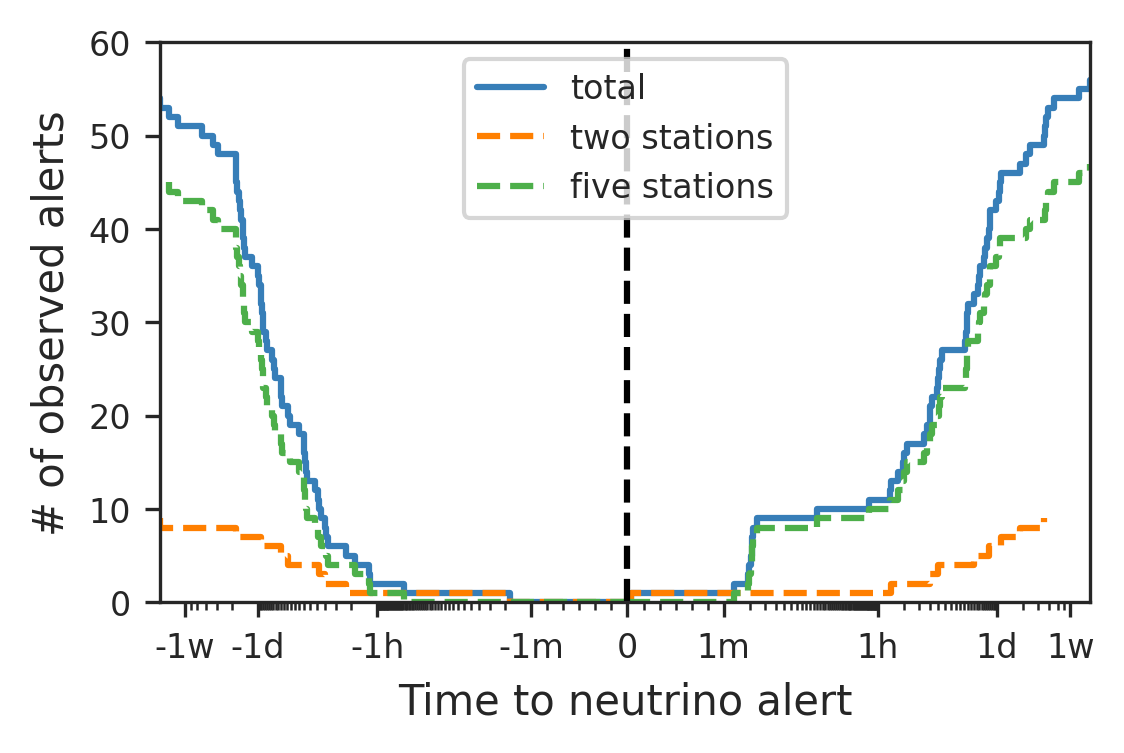

In [41]:
fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
fig.subplots_adjust(wspace=0.)

unmasked = [True] * len(alerts)

for m, c, ls, l in zip(
    [unmasked, ~alerts.five_stations, alerts.five_stations],
    [CB_color_cycle[0], CB_color_cycle[1], CB_color_cycle[2]],
    ["-", "--", "--"],
    ["total", "two stations", "five stations"]
):

    mbefore = (~alerts.Before.isna()) & ~alerts.Event.duplicated() & m
    sorted_before = alerts[mbefore].sort_values(by="Before", ignore_index=True, ascending=True)

    mafter = (~alerts.After.isna()) & ~alerts.Event.duplicated() & m
    sorted_after = alerts[mafter].sort_values(by="After", ignore_index=True)

    times_before = list(-sorted_before.Before[::-1]) + [0]
    times_after = [0] + list(sorted_after.After)
    N_before = list(sorted_before.index[::-1] + 1) + [0]
    N_after = [0] + list(sorted_after.index+1)

    ax.plot(times_before, N_before, drawstyle='steps-pre', color=c, ls=ls, label=l) 
    ax.plot(times_after, N_after, drawstyle='steps-post', color=c, ls=ls)
    
ax.set_xscale("symlog", linthresh=1/60)

ax.axvline(0, ls='--', color='k')

minor_ticks =  np.array(list(np.linspace(10, 50, 5)/3600) + list(np.linspace(1, 59, 59)/60) + list(range(1, 24)) + list(np.array(range(1, 7)) * 24) + list(np.array(range(1, 3))*24*7))
xticks = [1/60, 1, 24, 168]
xticklabels = ['1m', '1h', '1d', '1w']

ax.set_xticks(list(-np.array(xticks)) + [0] + xticks)
ax.set_xticklabels(["-" + xtl for xtl in xticklabels] + [0] + ["" + xtl for xtl in xticklabels])
ax.set_xticks(list(-minor_ticks) + list(minor_ticks), minor=True)
ax.set_xticklabels(['']*len(minor_ticks)*2, minor=True)

ax.set_ylim([0, 60])
ax.set_xlim([min(-alerts.Before), max(alerts.After)])

ax.set_xlabel('Time to neutrino alert')
ax.set_ylabel('# of observed alerts')
ax.legend()

plt.show()

In [42]:
two_st_yr = (five_st_time - min(times)).to("yr").value
total_yr = (max(times) - min(times)).to("yr").value
five_st_yr = total_yr - two_st_yr

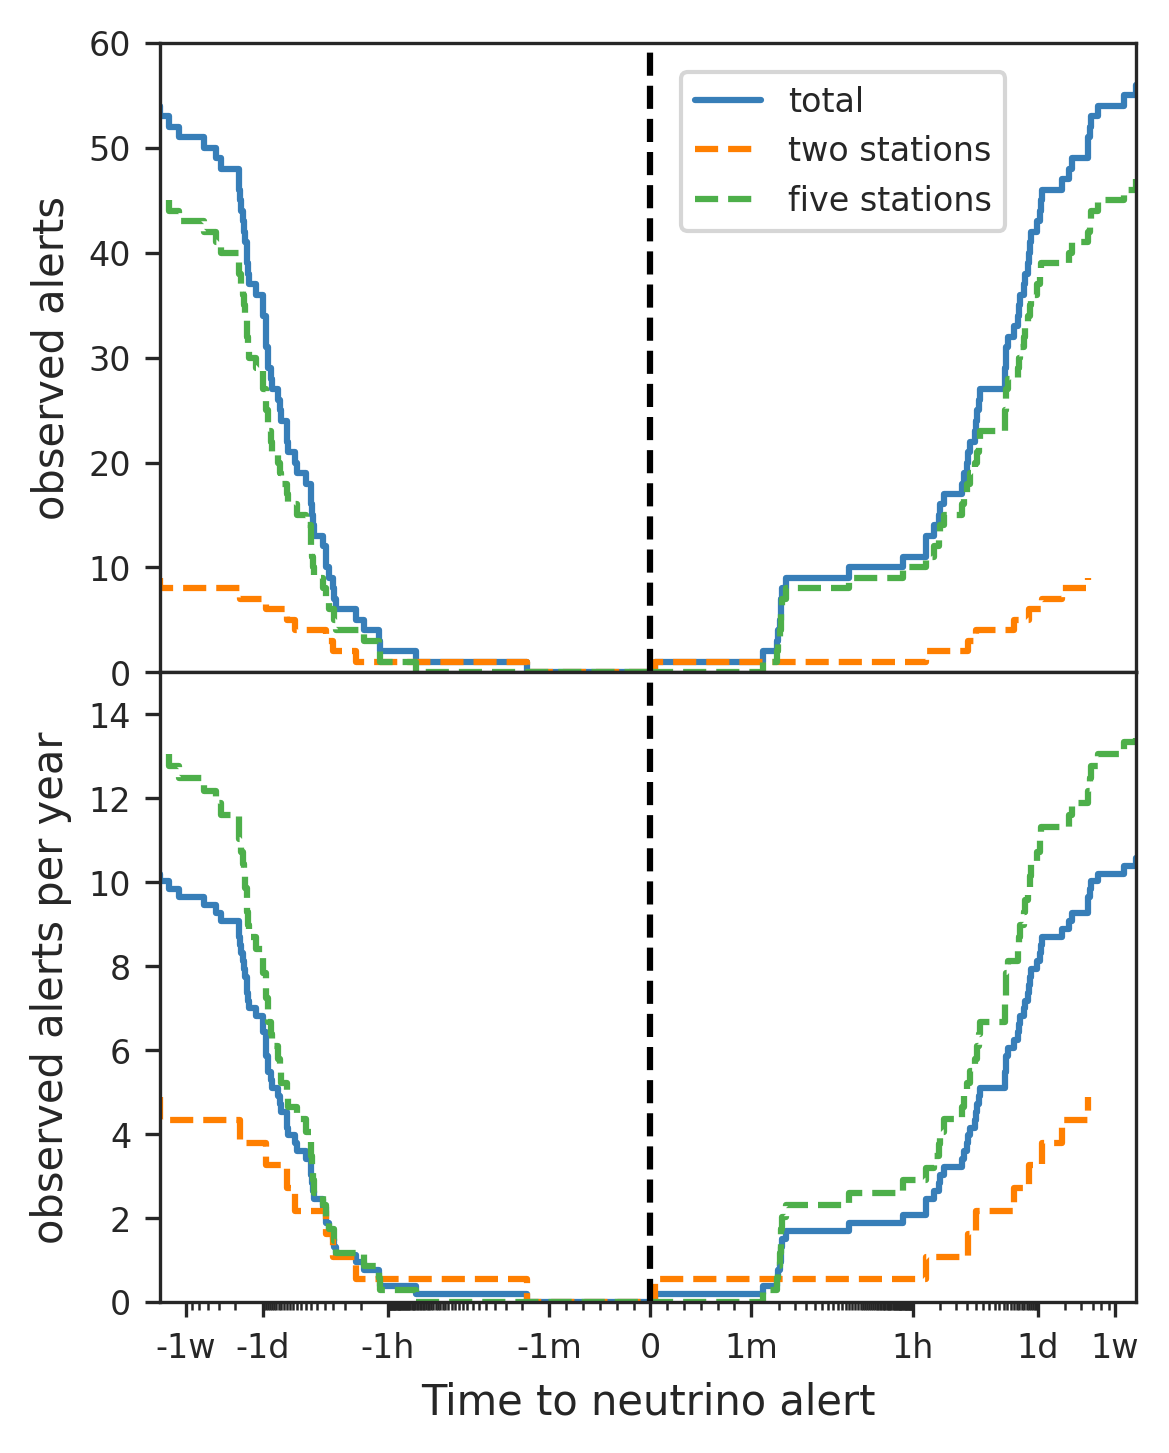

In [43]:
fig, (ax, ratioax) = plt.subplots(nrows=2, figsize=(base_width, 2*base_height), dpi=dpi,
                      gridspec_kw={'hspace': 0, 'height_ratios': [1, 1]}, sharex='col')
fig.subplots_adjust(wspace=0.)

unmasked = [True] * len(alerts)

for m, c, ls, l, normto in zip(
    [unmasked, ~alerts.five_stations, alerts.five_stations],
    [CB_color_cycle[0], CB_color_cycle[1], CB_color_cycle[2]],
    ["-", "--", "--"],
    ["total", "two stations", "five stations"],
    [total_yr, two_st_yr, five_st_yr]
):

    mbefore = (~alerts.Before.isna()) & ~alerts.Event.duplicated() & m
    sorted_before = alerts[mbefore].sort_values(by="Before", ignore_index=True, ascending=True)

    mafter = (~alerts.After.isna()) & ~alerts.Event.duplicated() & m
    sorted_after = alerts[mafter].sort_values(by="After", ignore_index=True)

    times_before = list(-sorted_before.Before[::-1]) + [0]
    times_after = [0] + list(sorted_after.After)
    N_before = list(sorted_before.index[::-1] + 1) + [0]
    N_after = [0] + list(sorted_after.index+1)

    ax.plot(times_before, N_before, drawstyle='steps-pre', color=c, ls=ls, label=l) 
    ax.plot(times_after, N_after, drawstyle='steps-post', color=c, ls=ls)
    
    ratioax.plot(times_before, np.array(N_before) / normto, drawstyle='steps-pre', color=c, ls=ls)
    ratioax.plot(times_after, np.array(N_after)/normto, drawstyle='steps-post', color=c, ls=ls)
    
ax.set_xscale("symlog", linthresh=1/60)

for a in [ax, ratioax]:
    a.axvline(0, ls='--', color='k')

minor_ticks =  np.array(list(np.linspace(10, 50, 5)/3600) + list(np.linspace(1, 59, 59)/60) + list(range(1, 24)) + list(np.array(range(1, 7)) * 24) + list(np.array(range(1, 3))*24*7))
xticks = [1/60, 1, 24, 168]
xticklabels = ['1m', '1h', '1d', '1w']

ax.set_xticks(list(-np.array(xticks)) + [0] + xticks)
ax.set_xticklabels(["-" + xtl for xtl in xticklabels] + [0] + ["" + xtl for xtl in xticklabels])
ax.set_xticks(list(-minor_ticks) + list(minor_ticks), minor=True)
ax.set_xticklabels(['']*len(minor_ticks)*2, minor=True)

ax.set_ylim([0, 60])
ratioax.set_ylim([0, 15])
ax.set_xlim([min(-alerts.Before), max(alerts.After)])

ratioax.set_xlabel('Time to neutrino alert')
ax.set_ylabel('observed alerts')
ratioax.set_ylabel("observed alerts per year")
ax.legend(bbox_to_anchor = (0.7,0.98), ncol=1, loc='upper center')

fig.tight_layout()

plt.show()

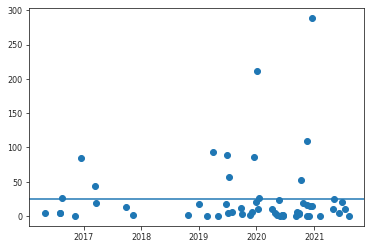

In [14]:
plt.scatter(times.to_datetime(), alerts.After)
plt.axhline(24)

In [20]:
coords = SkyCoord(alerts.RA, alerts.Dec, unit='deg')

In [22]:
dist_to_sun = coords.separation(get_sun(times))

In [23]:
dist_to_sun

<Angle [143.41928959, 167.89969259, 167.89969259,  86.31094146,
        154.82558501,   3.1115326 ,   0.83990982, 112.60090194,
         55.31312891, 164.65822719,  18.51541818, 100.56487866,
                 nan,  86.14118951,          nan,  59.59985901,
        138.23918886, 165.60606245,          nan, 107.25423301,
        152.22892951,          nan, 168.36737115, 128.52120945,
         22.49630702,  70.04513065,          nan, 115.77265107,
         66.87575438,  48.7828624 ,  31.78344669, 109.44506167,
         42.24356122,  69.02790919, 106.57919333, 139.93680227,
        110.61702188,  89.55300407,  41.06350573,  99.38246599,
         67.39779525,  29.0336551 ,  43.78424295,   9.10188573,
                 nan, 118.9322194 , 110.8664209 ,  38.3428801 ,
         39.3226564 , 142.87790335, 142.98003982, 111.33920369,
         84.32332049,  20.51425513,  32.3277311 ,          nan,
         35.8478409 ,  73.82326614,  24.00380745,  56.26753198,
         43.95855696,  46.96835181, 103.

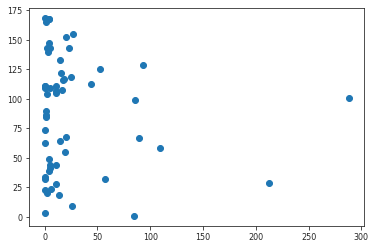

In [30]:
plt.scatter(alerts.After, dist_to_sun)

In [25]:
alerts.RA

23    240.57
24    214.50
24    214.50
25    122.81
26    200.30
       ...  
82    337.41
21    340.75
83     46.49
84    105.73
22    270.79
Name: RA, Length: 86, dtype: float64

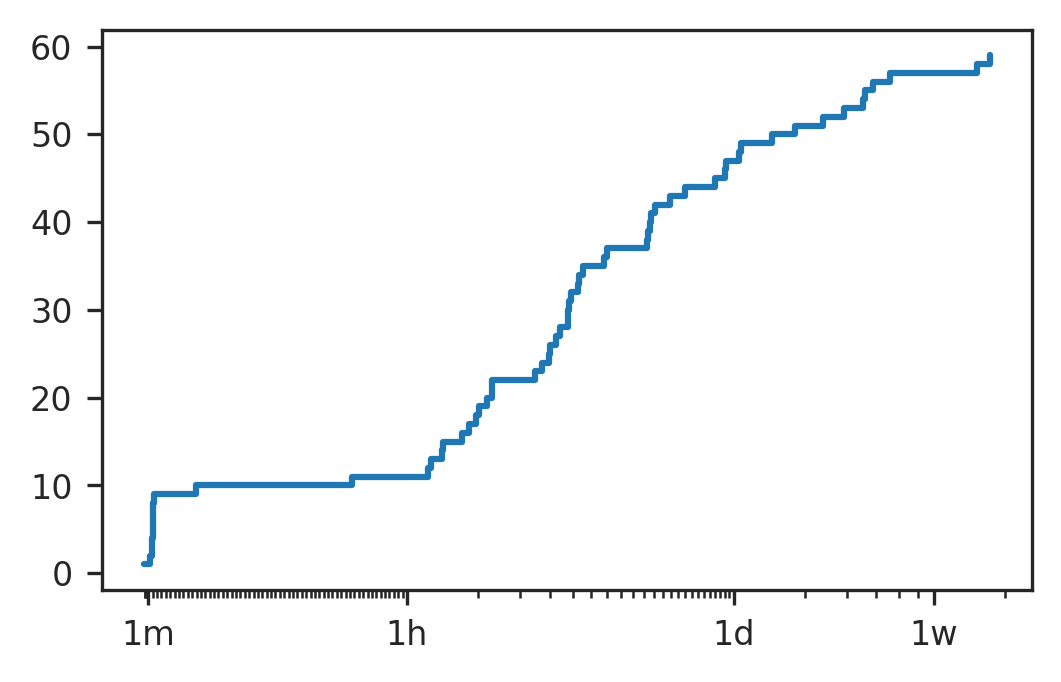

In [46]:
sorted_closest_obs = alerts.sort_values("closest_obs", ignore_index=True)

fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)

ax.plot(sorted_closest_obs.closest_obs, list(sorted_closest_obs.index + 1), drawstyle="steps-post")

ax.set_xscale("symlog", linthresh=1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['']*len(minor_ticks), minor=True)


plt.show()

In [29]:
sum(alerts.closest_obs[~alerts.retracted & ~ alerts.Event.duplicated()] < 24*2*7)

58

In [32]:
mmm = ~alerts.Before.isna() & alerts.After.isna()
alerts[mmm]

,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],Signalness,initial RA,initial Dec,...,5d coverage,6d coverage,7d coverage,14d coverage,observed,controll_Event,Before,After,closest_obs,closest_obs_side
61,IC200421A,BRONZE,87.93,"[3.44,-2.83]",8.23,"[2.09, -1.84]",2020-04-21 00:35:24.24,0.33312,89.2549,7.9065,...,0.0,0.0,0.0,0.0,False,IC200421A,69.78279,NaN,69.78279,Before
80,IC210516A,BRONZE,91.76,"[1.05, -0.97]",9.52,"[0.5, -0.58]",2021-05-16 14:38:20.33,0.28860,91.8213,9.7002,...,0.0,0.0,0.0,0.0,False,IC210516A,255.66738,NaN,255.66738,Before


(array([6., 5., 1., 1., 1., 0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  1.22562  ,   4.0970001,   6.9683802,   9.8397603,  12.7111404,
         15.5825205,  18.4539006,  21.3252807,  24.1966608,  27.0680409,
         29.939421 ,  32.8108011,  35.6821812,  38.5535613,  41.4249414,
         44.2963215,  47.1677016,  50.0390817,  52.9104618,  55.7818419,
         58.653222 ,  61.5246021,  64.3959822,  67.2673623,  70.1387424,
         73.0101225,  75.8815026,  78.7528827,  81.6242628,  84.4956429,
         87.367023 ,  90.2384031,  93.1097832,  95.9811633,  98.8525434,
        101.7239235, 104.5953036, 107.4

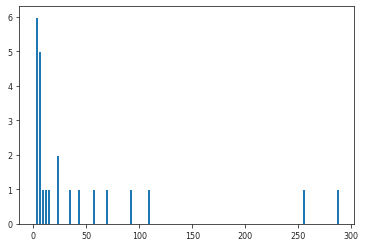

In [47]:
mmm = alerts.closest_obs_side == "Before"
plt.hist(alerts.closest_obs[mmm], bins=100)